In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

Parse and convert yellow taxi trip data from Parquet to CSV format.

In [52]:
# df_par = pd.read_parquet(r'../raw/yellow_tripdata_2019-01.parquet', engine='auto')
# df_par.to_csv(r'../raw/yellow_tripdata_2019-01.csv', index=False)

Data overview (yellow_tripdata_2019-01.csv)

In [12]:
df_csv = pd.read_csv(r'../raw/yellow_tripdata_2019-01.csv')
df_csv.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,NaN


In [13]:
df_csv.shape

(7696617, 19)

In [14]:
df_csv.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

Change date formatting (for convenience later on)

In [15]:
df_csv['tpep_pickup_datetime'] = pd.to_datetime(
    df_csv['tpep_pickup_datetime'], 
    format='%Y-%m-%d %H:%M:%S'
)

df_csv['tpep_dropoff_datetime'] = pd.to_datetime(
    df_csv['tpep_dropoff_datetime'],
    format='%Y-%m-%d %H:%M:%S'
)

### Checking for Missing values
We can fill in these missing values with:
- passenger_count: 0
- RatecodeID: 99
- store_and_fwd_flag: N
- congestion_surcharge: 0
- airport_fee: 0

In [51]:
df_csv[df_csv.columns].isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            28672
trip_distance                  0
RatecodeID                 28672
store_and_fwd_flag         28672
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4884887
airport_fee              7696617
dtype: int64

In [57]:
df_csv.fillna({
    'passenger_count': 0,
    'RatecodeID': 99,
    'store_and_fwd_flag': 'N',
    'congestion_surcharge': 0,
    'airport_fee': 0
}, inplace=True)
df_csv[df_csv.columns].isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

### Add mask
- Date (from 2019-01-01 to 2019-01-31)
- Total Amount (> 0 and < 1000)
- Passenger Count (> 0)
- Trip distance (> 0)
- All money-related columns (>= 0)

In [58]:
start_date = '2019-01-01'
end_date = '2019-02-01'

mask = (
    (df_csv['tpep_pickup_datetime'] >= start_date)
    & (df_csv['tpep_pickup_datetime'] < end_date)
    & (df_csv['tpep_pickup_datetime'] < df_csv['tpep_dropoff_datetime'])
    & (df_csv['total_amount'] < 1000)
    & (df_csv['total_amount'] > 0) 
    & (df_csv['passenger_count'] > 0)
    & (df_csv['trip_distance'] > 0)
    & (df_csv['fare_amount'] >= 0)
    & (df_csv['tip_amount'] >= 0)
    & (df_csv['extra'] >= 0)
    & (df_csv['mta_tax'] >= 0)
    & (df_csv['improvement_surcharge'] >= 0)
    & (df_csv['tolls_amount'] >= 0) 
    & (df_csv['congestion_surcharge'] >= 0)
    & (df_csv['airport_fee'] >= 0)
)

filtered_df = df_csv[mask]

In [62]:
pd.set_option('display.max_rows', None)
filtered_df.shape

(7490891, 19)

<Axes: xlabel='tpep_pickup_datetime'>

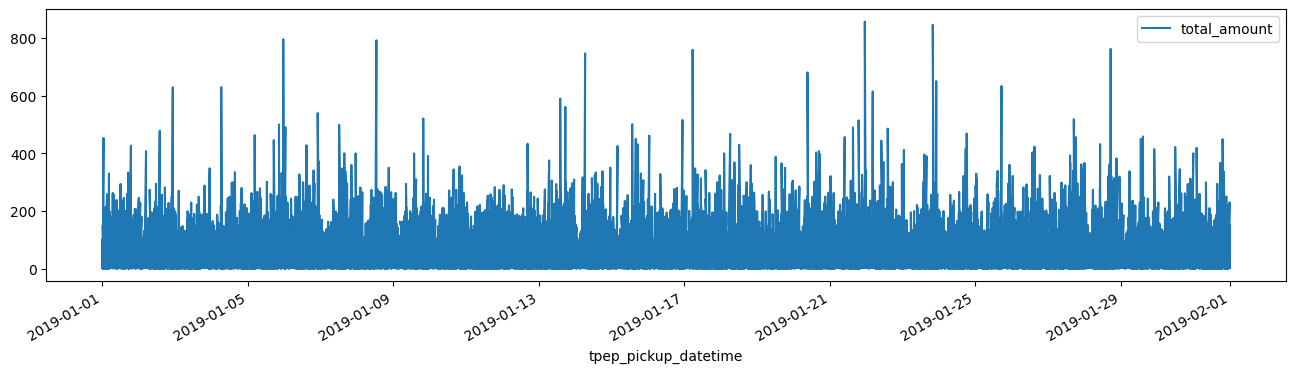

In [64]:
filtered_df.plot(
    x='tpep_pickup_datetime', 
    y='total_amount', 
    figsize=(16,4),
)